In [13]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

from VQLS import  estimateNorm
from LSSVM import predict, accuracy, linearKernel
import LSSVM
from VQLSSVM import VQLSSVM

In [14]:
shots = 10000
gamma = 0.01 # regularization parameter
testSize = 0.2
subsetSize = 7

In [15]:
vqlssvm = VQLSSVM(gamma, shots)

In [16]:
X, y = datasets.make_classification(
    n_samples=50, n_features=2, n_informative=2, n_redundant=0, random_state=45
)
y = np.where(y == 0, -1, 1)
xTrain, xTest, yTrain, yTest = train_test_split(
    X, y, test_size=testSize, random_state=42
)
subsetIndices = np.random.choice(np.arange(xTrain.shape[0]), subsetSize, replace=False)
xSubset = np.array([xTrain[i] for i in subsetIndices])
ySubset = np.array([yTrain[i] for i in subsetIndices])

LS-SVM Matrix: [[ 0.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
   1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]
 [ 1.00000000e+00  1.01488699e+02  1.60820425e+00 -1.24405025e-01
   5.56977755e-01  1.47743785e+00  1.13340159e+00  3.62647730e-01]
 [ 1.00000000e+00  1.60820425e+00  1.02180628e+02 -4.19607999e-01
  -6.53919136e-01  1.35153548e+00  2.19826295e+00  1.41090300e+00]
 [ 1.00000000e+00 -1.24405025e-01 -4.19607999e-01  1.00193892e+02
   7.61259655e-01  3.38391483e-02 -7.21264962e-01 -6.85978237e-01]
 [ 1.00000000e+00  5.56977755e-01 -6.53919136e-01  7.61259655e-01
   1.03764583e+02  1.24526026e+00 -2.33421750e+00 -2.75079038e+00]
 [ 1.00000000e+00  1.47743785e+00  1.35153548e+00  3.38391483e-02
   1.24526026e+00  1.01601111e+02  5.87713112e-01 -2.02175757e-01]
 [ 1.00000000e+00  1.13340159e+00  2.19826295e+00 -7.21264962e-01
  -2.33421750e+00  5.87713112e-01  1.03002272e+02  2.51490744e+00]
 [ 1.00000000e+00  3.62647730e-01  1.41090300e+00 -6.8

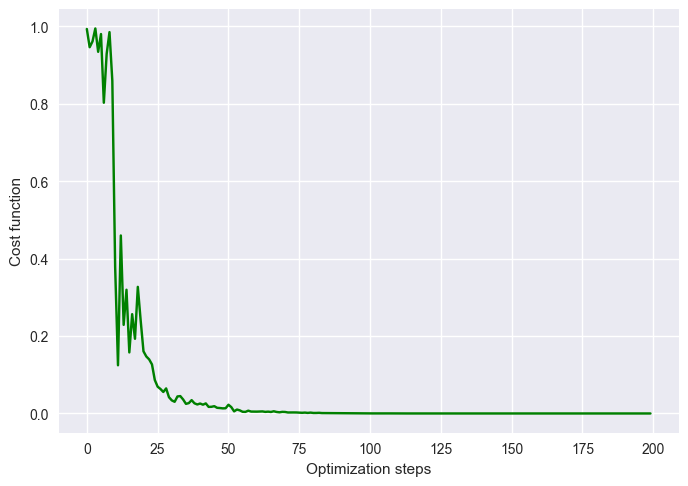

In [17]:
vqlssvm.train(xSubset, ySubset, quantumSimulation=False, verbose=True, iterations = 200)

vqlssvm.plotCost()

In [18]:
print(vqlssvm.predict(xTest))

[-0.0096103 +0.j  0.0484931 +0.j -0.00375767+0.j -0.04128373+0.j
  0.04768339+0.j  0.03285201+0.j  0.04099729+0.j -0.04096888+0.j
 -0.05361281+0.j  0.09237806+0.j]


In [19]:
 print("Accuracy:",vqlssvm.accuracy(xTest, yTest))

Accuracy: 0.6


LS-SVM Matrix: [[ 0.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
   1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]
 [ 1.00000000e+00  1.01488699e+02  1.60820425e+00 -1.24405025e-01
   5.56977755e-01  1.47743785e+00  1.13340159e+00  3.62647730e-01]
 [ 1.00000000e+00  1.60820425e+00  1.02180628e+02 -4.19607999e-01
  -6.53919136e-01  1.35153548e+00  2.19826295e+00  1.41090300e+00]
 [ 1.00000000e+00 -1.24405025e-01 -4.19607999e-01  1.00193892e+02
   7.61259655e-01  3.38391483e-02 -7.21264962e-01 -6.85978237e-01]
 [ 1.00000000e+00  5.56977755e-01 -6.53919136e-01  7.61259655e-01
   1.03764583e+02  1.24526026e+00 -2.33421750e+00 -2.75079038e+00]
 [ 1.00000000e+00  1.47743785e+00  1.35153548e+00  3.38391483e-02
   1.24526026e+00  1.01601111e+02  5.87713112e-01 -2.02175757e-01]
 [ 1.00000000e+00  1.13340159e+00  2.19826295e+00 -7.21264962e-01
  -2.33421750e+00  5.87713112e-01  1.03002272e+02  2.51490744e+00]
 [ 1.00000000e+00  3.62647730e-01  1.41090300e+00 -6.8

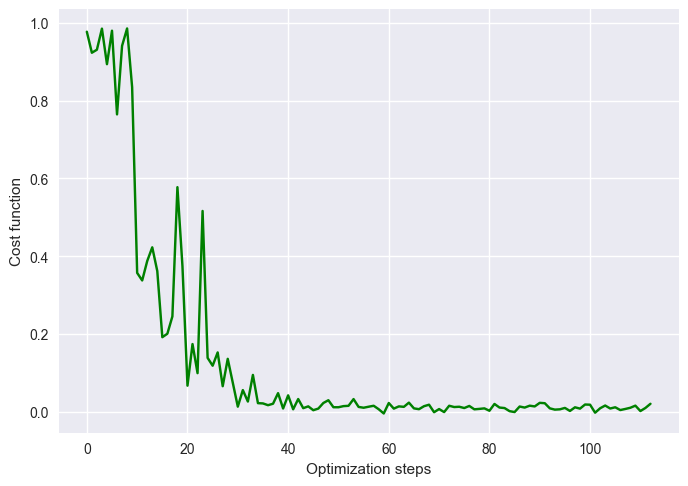

In [20]:
vqlssvm.train(xSubset, ySubset, quantumSimulation=True, verbose=True, iterations = 200)

vqlssvm.plotCost()

In [22]:
print("Predictions: ", vqlssvm.predict(xTest))
print("Accuracy: ", vqlssvm.accuracy(xTest, yTest))

Predictions:  [-0.01375643+0.j  0.05171064+0.j -0.0009704 +0.j -0.03802609+0.j
  0.0577619 +0.j  0.04072894+0.j  0.04129943+0.j -0.03707956+0.j
 -0.0486766 +0.j  0.11283135+0.j]
Accuracy:  0.6
